# Descrição dos Dados

A indústria Gelatina Ltda. está analisando a possibilidade de implementação de uma rede neural
Perceptron para controlar (ligar ou desligar) o motor de um processo específico de sua linha de produção.
Durante o período de 1 mês realizou-se a aquisição dos dados relativos às variáveis de entrada (Pressão e
Temperatura) e saída (Acionamento do motor), ou seja, monitorou-se o comportamento do processo.

O dataset em questão é composto por 386 linhas e 3 colunas, onde, contextualmete representam duas entradas e uma saída binária representando sua classe.

<h2>Dicionário</h2>

X1 -> Pressão | Float64
<br />
X2 -> Temperatura | Float64
<br />
Y -> Desligar o motor (0) ou Ligar o motor(1) | Int64

# Dependências

In [ ]:
# Deps
!pip install --user numpy
!pip install --user pandas
!pip install --user openpyxl
!pip install --user matplotlib
!pip install --user seaborn
!pip install --user scikit-learn

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Visualização dos Dados

In [3]:
# Importando o arquivo xlsx com os dados
motor_df = pd.read_excel("rna_database.xlsx", decimal=".", header=0)
motor_df.head()

,X1,X2,Y
0,-0.215326,-0.288510,0
1,-0.263642,-0.673541,0
2,-0.843519,0.215869,0
3,-0.934878,0.551532,0
4,-0.017532,0.244474,0


In [4]:
# A base de dados é composta por 386 dados contendo duas entradas X1 X2 e uma saída Y.
motor_df.shape

(386, 3)

In [5]:
motor_df.describe()

,X1,X2,Y
count,386.000000,386.000000,386.000000
mean,0.160199,0.012703,0.507772
std,0.604064,0.686653,0.500588
min,-0.988142,-0.999918,0.000000
25%,-0.344689,-0.637910,0.000000
50%,0.302345,-0.003418,1.000000
75%,0.697541,0.716575,1.000000
max,0.998171,1.000000,1.000000


In [6]:
# Há dados nulos?
motor_df.isnull().sum()

X1    0
X2    0
Y     0
dtype: int64

In [7]:
motor_df.dtypes

X1    float64
X2    float64
Y       int64
dtype: object

# Demonstração dos Dados

In [8]:
# Transformando os dados em um array
X1 = motor_df.iloc[:, 0].to_numpy()
X2 = motor_df.iloc[:, 1].to_numpy()

<Axes: xlabel='X1', ylabel='X2'>

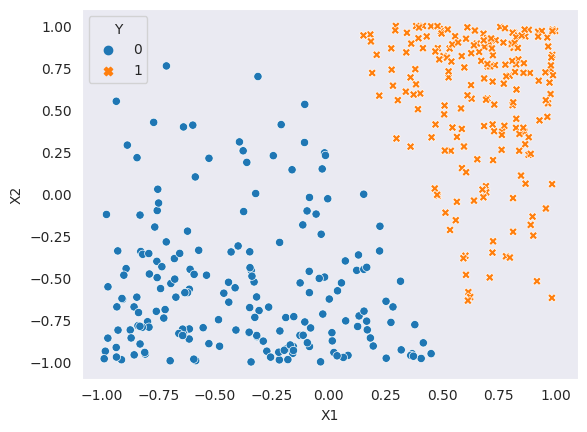

In [9]:
sns.set_style("dark")
sns.scatterplot(data=motor_df, x="X1", y = "X2", hue="Y", style="Y")

Nota-se que em questão de dispersão de dados, os dois conseguem se dinstinguir de forma eficaz e sem invasões, oque ajuda muito para o uso de uma rede como a <strong>Perceptron</strong>, que utiliza apenas uma função de reta.

## Outliers

Geralmente em uma base de dados ocorrem a existência de dados fora do comum, chamados de outlier, que podem prejudicar a análise e o uso da rede.

<Axes: >

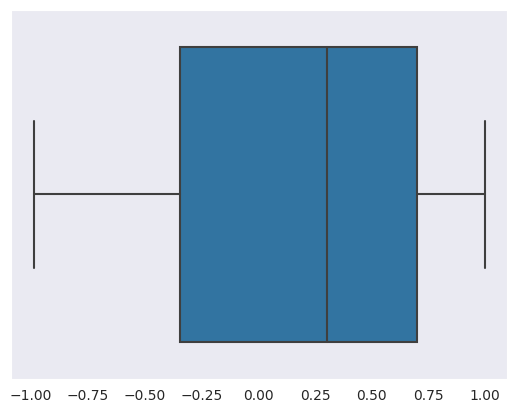

In [10]:
sns.boxplot(x=X1)

<Axes: >

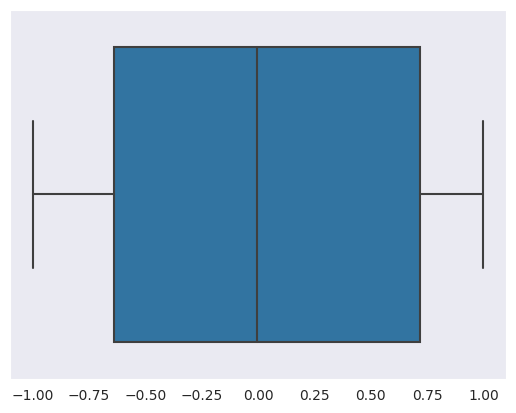

In [11]:
sns.boxplot(x=X2)

Neste caso, não há a existência de dados fora do comum, ou seja, todos eles estão de alguma forma dentro de seus padrões, oque ajuda na hora de distingui-los na análise futura.

# Organizando os Dados

In [12]:
# Treinamento 70% - 30%

class_off = motor_df.loc[motor_df['Y'] == 0]
class_on = motor_df.loc[motor_df['Y'] == 1]

class_on = class_on.reset_index(drop=True)

class_off_train = class_off.iloc[:(round(len(class_off) * 0.7)),]
class_on_train = class_on.iloc[:(round(len(class_on)*0.7)),]

class_on_test = class_on.iloc[(round(len(class_on_train))):]
class_off_test = class_off.iloc[(round(len(class_off_train))):]

In [13]:
# Resetando os dois index

class_on_test = class_on_test.reset_index(drop=True)
class_off_test = class_off_test.reset_index(drop=True)

In [14]:
# Os dados foram organizados de forma correta?

if (len(class_off_test) + len(class_off_train) + len(class_on_test) + len(class_on_train)) == 386 :
    print("Dados estão organizados de forma correta")
    print("Classe 0 de teste: "+ str(len(class_off_test)))
    print("Classe 0 de treino "+ str(len(class_off_train)))
    print("Total: "+str(len(class_off_test) + len(class_off_train)))
    print("\n")
    print("Classe 1 de teste: "+ str(len(class_on_test)))
    print("Classe 1 de treino: "+ str(len(class_on_train)))
    print("Total: "+str(len(class_on_test) + len(class_on_train)))
else:
    print("Dados estão organizados de forma errada")

Dados estão organizados de forma correta
Classe 0 de teste: 57
Classe 0 de treino 133
Total: 190


Classe 1 de teste: 59
Classe 1 de treino: 137
Total: 196


In [15]:
# Mesclando os dados de teste
test_df = pd.concat([class_off_test,class_on_test], ignore_index=True)
# Mesclando os dados de treino
train_df = pd.concat([class_off_train, class_on_train], ignore_index=True)

In [16]:
test_df_Y = test_df['Y'] # Saída esperada

test_df = test_df.drop(columns=['Y']) # Dados de treino

In [17]:
test_df_Y

0      0
1      0
2      0
3      0
4      0
      ..
111    1
112    1
113    1
114    1
115    1
Name: Y, Length: 116, dtype: int64

In [18]:
train_df.shape

(270, 3)

In [19]:
test_df.shape

(116, 2)

In [20]:
# Exportando os dados para CSV
motor_df.to_csv('dataset.csv')
train_df.to_csv('train-data.csv')
test_df.to_csv('test-data.csv')

# Modelo Perceptron

In [21]:
# Função degrau
def degrau_func(x):
    if(x>0):
        return 1
    return 0

In [22]:
import random

#bias
bias = round(random.uniform(0,1), 2) # Uniform - Gera valores floats dentro de um intervalo

# pesos
p1 = round(random.uniform(0,1), 2)
p2 = round(random.uniform(0,1), 2)

In [23]:
# Entradas de teste
test_matrix = test_df.to_numpy() # 0 - 115
test_matrix_y = test_df_Y.to_numpy()

# Entradas de treino
train_matrix = train_df.to_numpy()

In [147]:
class Perceptron:
    limit = 0 # limiar inicial
    w = [0,0] # pesos iniciais
    learning_rate = 0
    epoch = 0
    
    def parameters(self):
        print("Limiar: " + str(self.limit))
        print("Pesos: " + str(self.w))
        print("Épocas: " + str(self.epoch))
    
    def train(self,inputs_train, epoch): #O(n^2)
        st = time.process_time()
        error = 1
        while error == 1:
                self.epoch = self.epoch + 1
                error = 0
                for x in inputs_train:
                    x1w1 = x[0]*self.w[0]
                    x2w2 = x[1]*self.w[1]

                    sigma = (self.limit * -1) + (x1w1 + x2w2) 
                    y = degrau_func(sigma)
                    #print("Y Result = "+str(y)+" Y Expected = "+str(x[2]))
                    
                    if(y != x[2]):
                        error = 1
                        self.w[0] = self.w[0] + self.learning_rate*(x[2]-y)*x[0] # Ajuste do peso 1
                        self.w[1] = self.w[1] + self.learning_rate*(x[2]-y)*x[1] # Ajuste do peso 2
                        self.limit = self.limit + self.learning_rate*(x[2]-y)*-1 
        
        
                    
        et = time.process_time()
        
        print("Tempo de processamento: "+ str(et-st))
        
    def test(self,input_test):
        results = []
        
        st = time.process_time()
        for x in input_test:
            x1w1 = x[0]*self.w[0]
            x2w2 = x[1]*self.w[1]

            sigma = (self.limit * -1) + (x1w1+x2w2)
            y = degrau_func(sigma)
            
            results.append(y)
        et = time.process_time()
        
        elapsed_time = et - st
        
        print("Tempo de processamento(Teste): "+ str(elapsed_time/len(results)))
        return results

    
    def __init__(self, limit, learning_r):
        self.w[0] = round(random.uniform(0,1), 2)
        self.w[1] = round(random.uniform(0,1), 2)
        self.limit = limit
        self.learning_rate = learning_r
   

In [187]:
model = Perceptron(0.5, 0.85)

In [188]:
model.train(train_matrix, 10)
model.parameters()

Tempo de processamento: 0.0009614319999968757
Limiar: 0.5
Pesos: [1.6610675824257015, 0.7077357718783214]
Épocas: 3


## Teste

In [189]:
# Realizando teste
results = model.test(test_matrix)

Tempo de processamento(Teste): 1.0331293102855601e-06


In [190]:
results_data = []
for i in range(len(results)):
    results_data.append( [results[i], test_matrix_y[i]])

In [191]:
def reliability_percent(results_data): # [obtido, esperado]
    total = len(results_data) # total de dados
    errors = 0
    for result in results_data:
        if(result[0] != result[1]):
            errors = errors+1
    return ((total-errors)/total)*100

In [192]:
reliability_percent(results_data) # Taxa de acerto

100.0

## Plotando graficos de treino e teste

In [193]:
# Equação da Reta
w1 = model.w[0]
w2 = model.w[1]
limit = model.limit
x = np.linspace(-1,1) 
def f(x):
    return (-(w1/w2)*x + limit/w2)

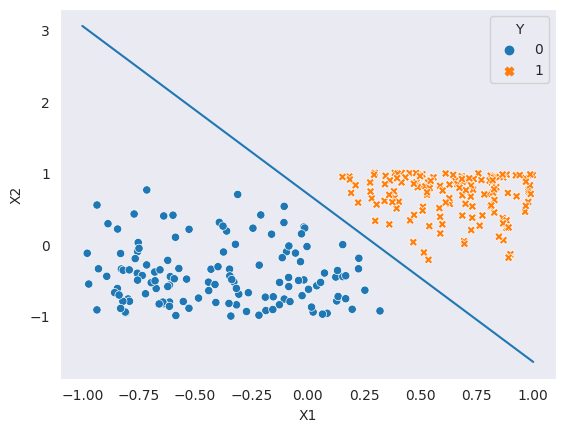

In [194]:
# Grafico de dispersão para os dados de treino

sns.set_style("dark")
sns.scatterplot(data=train_df, x='X1', y = 'X2', hue="Y", style = "Y")
#plt.plot(cord[0],cord[1], linewidth=1)
plt.plot(x,f(x))

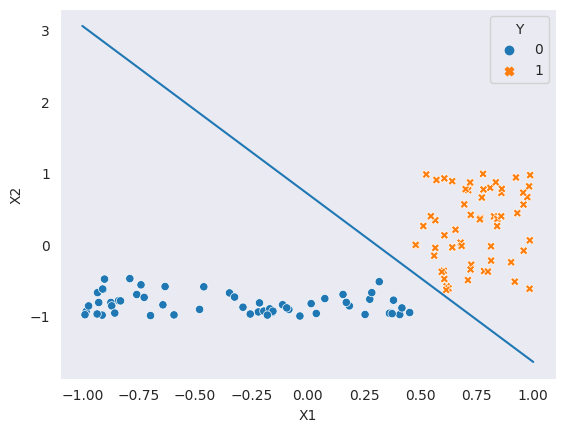

In [195]:
# Grafico de dispersão para os dados de teste
test_df_plot = test_df.assign(Y=test_matrix_y) # Adicionando novamente os Y aos dados de teste

sns.set_style("dark")
sns.scatterplot(data=test_df_plot, x="X1", y="X2", hue="Y", style='Y')
plt.plot(x,f(x))


## Matriz de confusão

<Axes: >

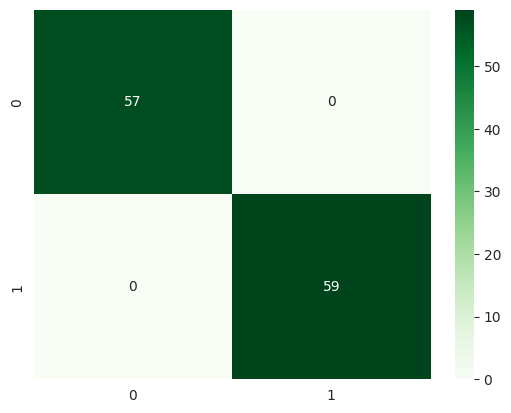

In [196]:
from sklearn.metrics import confusion_matrix

confusion_matrix_data = confusion_matrix(test_matrix_y, results)
sns.heatmap(confusion_matrix_data,annot=True,cmap="Greens")